In [153]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.skbn as skbn
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

pd.set_option('future.no_silent_downcasting', True)

In [154]:
df = pd.read_pickle("./df_causal_discovery.p")
df.head()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0


In [155]:
df.describe()

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
count,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000,29170.000000
mean,38.655674,40.447755,0.052348,0.406616,0.878334,0.331916,0.245835
std,13.722408,12.417203,0.222732,0.491211,0.326905,0.470909,0.430588
min,17.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,40.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,45.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,90.000000,99.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [156]:
disc = skbn.BNDiscretizer(defaultDiscretizationMethod="NoDiscretization", defaultNumberOfBins=None)
template = disc.discretizedBN(df[["age", "hasGraduateDegree", "greaterThan50k"]])
template.addArcs([("age","hasGraduateDegree"), ("age", "greaterThan50k"), ("hasGraduateDegree", "greaterThan50k")])

In [157]:
template

(pyAgrum.BayesNet<double>@0x58635642e2a0) BN{nodes: 3, arcs: 3, domainSize: 292, dim: 291, mem: 3Ko 1016o}

In [158]:
p_learner = gum.BNLearner(df, template)
p_learner.useNMLCorrection()
p_learner.useSmoothingPrior(1e-9)

bn = gum.BayesNet(template)
p_learner.fitParameters(bn)

print(p_learner)

Filename       : /tmp/tmpdc2pm093.csv
Size           : (29170,3)
Variables      : age[73], hasGraduateDegree[2], greaterThan50k[2]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000000



In [159]:
cbn = csl.CausalModel(bn)

In [160]:
T = "hasGraduateDegree"
Y = "greaterThan50k"
X = "age"

In [161]:
csl.causalImpact(cbn, on=Y, doing=T, values={T:1})

(<pyAgrum.causal._CausalFormula.CausalFormula at 0x7564c676bb80>,
 (pyAgrum.Potential<double>@0x5863552f5060) 
   greaterThan50k   |
 0        |1        |
 ---------|---------|
  0.5346  | 0.4654  |,
 "backdoor ['age'] found.")

In [162]:
cslnb.showCausalImpact(cbn, on=Y, doing=T, values={T:1}) 

$$\begin{equation*}P( greaterThan50k \mid \text{do}(hasGraduateDegree)) = \sum_{age}{P\left(greaterThan50k\mid age,hasGraduateDegree\right) \cdot P\left(age\right)}\end{equation*}$$

In [163]:
_,cpt0,_ = csl.causalImpact(cbn, on=Y, doing=T, knowing={X}, values={T:0})
_,cpt1,_ = csl.causalImpact(cbn, on=Y, doing=T, knowing={X}, values={T:1})

CATE = (cpt1 - cpt0).topandas()
CATE = CATE[Y]["1"]
CATE.head()

age
17    5.000000e-01
18    9.980880e-10
19    4.969651e-01
20    9.985465e-10
21   -3.076922e-03
Name: 1, dtype: float64

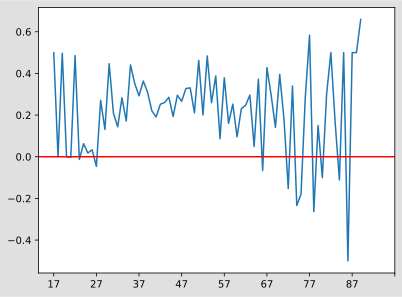

In [164]:
fig, ax = plt.subplots()

ax.plot(CATE)
ax.set_xticks(np.arange(0, 90, 10))
ax.axhline(y=0, color="r")
plt.show()

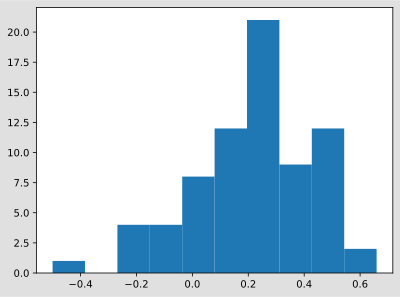

In [165]:
plt.hist(CATE)
plt.show()

In [166]:
def mutilateBN(bn : gum.BayesNet) -> gum.BayesNet:
    """
    Returns a copy of the Bayesian Network with all incoming arcs to the variable T removed.
    """
    res = gum.BayesNet(bn)
    for p_id in bn.parents(T):
        res.eraseArc(p_id, bn.idFromName(T))
    return res

def ATE(bn, X = {}, mutilate = True):
    ie = gum.LazyPropagation(mutilateBN(bn)) if mutilate else gum.LazyPropagation(bn)

    ie.setEvidence({T: 0} | X)
    ie.makeInference()
    p0 = ie.posterior(Y)

    ie.chgEvidence(T,1)
    ie.makeInference()
    p1 = ie.posterior(Y)

    diff = p1 - p0
    return diff.expectedValue(lambda d : diff.variable(0).numerical(d[diff.variable(0).name()]))

In [167]:
ATE(bn)

0.2332334047559898

In [172]:
import sklearn.linear_model as sklearn_linear_model
import sklearn.ensemble as sklearn_ensemble


def clip_probabilities(prob, th=0.1) :
  prob[prob < th] = th
  prob[prob > (1-th)] = 1-th
  return prob 

   
def estimate_ipw_weights(df, covariate_variable_l, is_parametric, clip_probabilities=False):
  if is_parametric:
    # estimate propensity scores without and with extended set
    propensity_model = sklearn_linear_model.LogisticRegression(random_state=0, fit_intercept=True).fit(X=df[covariate_variable_l].to_frame(), y=df["hasGraduateDegree"])
  else:
    propensity_model = sklearn_ensemble.RandomForestClassifier(n_estimators = 100, random_state = 0, min_samples_leaf=1).fit(df[covariate_variable_l], df["hasGraduateDegree"])
  estimates_prob = propensity_model.predict_proba(df[covariate_variable_l].to_frame())[:, 1]
  if clip_probabilities:
    estimates_prob = clip_probabilities(estimates_prob)
  return estimates_prob
        
    
def estimate_ipw(df, covariate_variable_l, is_parametric=True, clip_probabilities=False):
  # compute estimates
  Y = df["greaterThan50k"].to_numpy()
  A = df["hasGraduateDegree"].to_numpy()
  e_hat = estimate_ipw_weights(df, covariate_variable_l, is_parametric=is_parametric, clip_probabilities=clip_probabilities)
  return (Y * ((A/e_hat) - (1-A)/(1-e_hat))).mean()

In [173]:
estimate_ipw(df, X)

0.2903849161738249

In [174]:
df.columns

Index(['age', 'hours-per-week', 'hasGraduateDegree', 'inRelationship',
       'isWhite', 'isFemale', 'greaterThan50k'],
      dtype='object')

In [176]:
disc = skbn.BNDiscretizer(defaultNumberOfBins=5, defaultDiscretizationMethod="uniform")
template = disc.discretizedBN(df)

In [177]:
s_learner = gum.BNLearner(df, template)
s_learner.useNMLCorrection()
s_learner.useSmoothingPrior(1e-6)
#s_learner.setSliceOrder([["X3"], ["X1","X2","V1","V2","V3"], ["T"], ["Y"]])
bn2 = s_learner.learnBN()

print(s_learner)

Filename       : /tmp/tmpvrspbezj.csv
Size           : (29170,7)
Variables      : age[5], hours-per-week[5], hasGraduateDegree[2], inRelationship[2], isWhite[2], isFemale[2], greaterThan50k[2]
Induced types  : False
Missing values : False
Algorithm      : MIIC
Score          : BDeu  (Not used for constraint-based algorithms)
Correction     : NML  (Not used for score-based algorithms)
Prior          : Smoothing
Prior weight   : 0.000001



In [178]:
bn2

(pyAgrum.BayesNet<double>@0x586355265650) BN{nodes: 7, arcs: 13, domainSize: 800, dim: 220, mem: 2Ko 464o}

In [179]:
cbn2 = csl.CausalModel(bn2)

In [181]:
cslnb.showCausalImpact(cbn2, on=Y, doing=T, values={T:1}) 

In [184]:
ATE(bn2)

0.3251771171062001